In [2]:
## Import Pandas to allow for read of the University of Michigan dataset in tsv format, 
## including quick head() method preview to ensure the dataset loaded properly
import pandas as pd

df = pd.read_csv('data/36361-0001-Data.tsv', sep='\t')
df.head()

,CASEID,QUESTID2,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,II2EMST4,PRXRETRY,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,GQTYPE2
0,1,85314767,1,99,99,16,9999,99,4,93,...,1,99,2,2,2,2,8587.828634,40025,2,-9
1,2,16240983,1,99,99,16,9999,99,1,1,...,1,99,1,1,2,2,4260.686570,40041,1,-9
2,3,95206287,2,99,99,991,9991,91,91,91,...,1,99,2,2,2,2,874.478772,40010,1,-9
3,4,91546127,2,99,99,991,9991,91,91,91,...,1,99,1,1,2,2,4816.381147,40019,2,-9
4,5,43902390,2,99,99,991,9991,91,91,91,...,1,99,1,1,2,2,18967.391778,40016,2,-9


In [3]:
## PDF Reader library imported to scrape the text form the PDF, looking specifically for those column header codes & building a 
## library that includes their full descipription.  Minimizes questions when reviewing the initial dataset w/ full 
## descrioptions mapped in, too.
from PyPDF2 import PdfReader
import pandas as pd
import re

pdf_path = "data/36361-0001-Codebook.pdf"
reader = PdfReader(pdf_path)
pattern = r"(.*?)\s*Len:\s*(\d+)\s*(.*)"

values = []

for page in reader.pages[2:]:
    # Extract the text from the page
    text = page.extract_text()
    if text:
        for line in text.splitlines():
            match = re.search(pattern, line)
            if match:
                var_name = match.group(1).strip()         
                len_number = match.group(2).strip()      
                description = match.group(3).strip()   
                description = var_name + ": " + re.sub(r"\b(freq|pct)\b.*", "", description, flags=re.IGNORECASE).strip()
                values.append([var_name, description])
headers = pd.DataFrame(values, columns=["Column Code", "Full Description"])

print(headers.head())

  Column Code                                   Full Description
0    QUESTID2                QUESTID2: RESPONDENT IDENTIFICATION
1    FILEDATE           FILEDATE: CREATION DATE OF THE DATA FILE
2     CIGEVER                   CIGEVER: EVER SMOKED A CIGARETTE
3    CIGOFRSM  CIGOFRSM: IF BEST FRIEND OFFERED, WOULD YOU SM...
4    CIGWILYR  CIGWILYR: DO YOU THINK YOU'LL SMOKE CIG IN NEX...


In [4]:
## Take steps below to officially map the above scrape details to the datafrmae column headers
## for greater ease in identifying column feature/influences.
mapping = dict(zip(headers["Column Code"], headers["Full Description"]))
df_desc = df.rename(columns=mapping)
df_desc.head()

,CASEID,QUESTID2: RESPONDENT IDENTIFICATION,CIGEVER: EVER SMOKED A CIGARETTE,"CIGOFRSM: IF BEST FRIEND OFFERED, WOULD YOU SMOKE CIG",CIGWILYR: DO YOU THINK YOU'LL SMOKE CIG IN NEXT 12 MOS,CIGTRY: AGE WHEN FIRST SMOKED A CIGARETTE,CIGYFU: YEAR OF FIRST CIGARETTE USE - RECODE,CIGMFU: MONTH OF FIRST CIGARETTE USE - RECODE,CIGREC: TIME SINCE LAST SMOKED CIGARETTES,CIG30USE: HOW MANY DAYS SMOKED CIG IN PAST 30 DAYS,...,II2EMST4: IMP. IND. EMPLOYMENT STATUS 18+ (DETAILS),"PRXRETRY: SELECTED PROXY UNAVAILABLE, OTHER PROXY AVAILABLE?",PDEN10: POPULATION DENSITY 2010 - THREE LEVELS,COUTYP2: COUNTY METRO/NONMETRO STATUS (3 -LEVEL),MAIIN102: MAJORITY AMER INDIAN AREA INDICATOR FOR SEGMENT,AIIND102: AMER INDIAN AREA INDICATOR,ANALWT_C: FIN PRSN -LEVEL SMPLE WG HT,VESTR: ANALYSIS STRATUM,VEREP: ANALYSIS REPLICATE,GQTYPE2
0,1,85314767,1,99,99,16,9999,99,4,93,...,1,99,2,2,2,2,8587.828634,40025,2,-9
1,2,16240983,1,99,99,16,9999,99,1,1,...,1,99,1,1,2,2,4260.686570,40041,1,-9
2,3,95206287,2,99,99,991,9991,91,91,91,...,1,99,2,2,2,2,874.478772,40010,1,-9
3,4,91546127,2,99,99,991,9991,91,91,91,...,1,99,1,1,2,2,4816.381147,40019,2,-9
4,5,43902390,2,99,99,991,9991,91,91,91,...,1,99,1,1,2,2,18967.391778,40016,2,-9


In [8]:
##  Specifying the columns we are wanting to measure correlation on in comparison to the target column while also elmiinating any rows that 
##  do not contain actual subject responses.  Such responses are coded with a valuv of 90, or above.
columns_to_filter = ['DEPNDIEM', 'COCEMCTD', 'DEPNDPSY', 'ILLPFMLY', 'SERVICE']
target_column = 'DEPNDCOC' 

condition = True
for col in columns_to_filter:
    condition &= (df[col] < 90)
filtered_df = df[condition]

correlations = {col: filtered_df[col].corr(filtered_df['DEPNDCOC']) for col in columns_to_filter}
correlations_series = pd.Series(correlations)
sorted_correlations = correlations_series.abs().sort_values(ascending=False)
print(sorted_correlations)

DEPNDIEM    0.838386
COCEMCTD    0.501517
DEPNDPSY    0.190381
SERVICE     0.100504
ILLPFMLY    0.025569
dtype: float64


In [11]:
##  Next, we are preparing the Logistic Regression model for training & testing predictive outcomes on the 20% of sample data reserved
##  from the original dataset.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

X = filtered_df[columns_to_filter]
y = filtered_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print(X.describe())
print(y_train.value_counts())
print(classification_report(y_test, y_pred))

Accuracy: 0.9666666666666667
Confusion Matrix:
 [[11  1]
 [ 0 18]]
         DEPNDIEM    COCEMCTD    DEPNDPSY    ILLPFMLY     SERVICE
count  149.000000  149.000000  149.000000  149.000000  149.000000
mean     0.684564    1.422819    0.255034    0.093960    2.496644
std      0.466257    0.495673    0.437350    0.292757    6.808802
min      0.000000    1.000000    0.000000    0.000000    1.000000
25%      0.000000    1.000000    0.000000    0.000000    2.000000
50%      1.000000    1.000000    0.000000    0.000000    2.000000
75%      1.000000    2.000000    1.000000    0.000000    2.000000
max      1.000000    2.000000    1.000000    1.000000   85.000000
DEPNDCOC
1    72
0    47
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.95      1.00      0.97        18

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg    

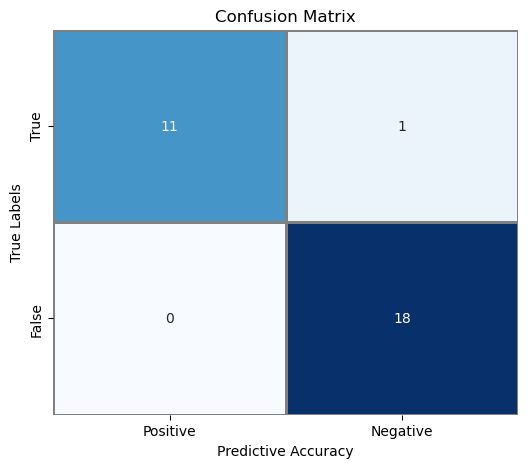

In [15]:
##  The next logical step, I thought, was to create a confusion matric to get a visukal on how well the predictive model 
##  is performing agains the test dataset.
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))  # Adjust size as needed
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Positive", "Negative"], 
            yticklabels=["True", "False"], 
            cbar=False, linewidths=1, linecolor='gray')

# Add axis labels and title
plt.xlabel('Predictive Accuracy')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

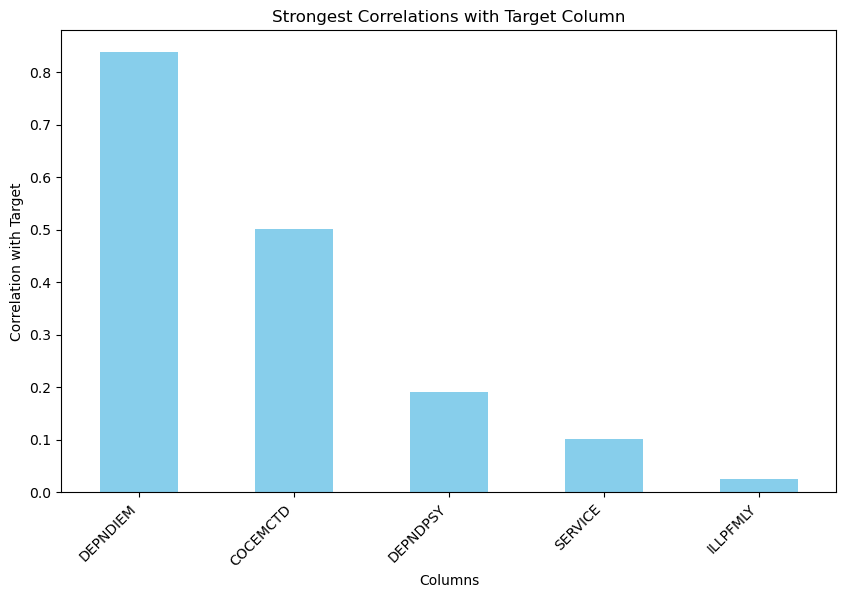

In [16]:
##  Lastly, the correlations for the hypothesized correlates are prepared in a bar graph to grant ourselves a visual on those
##  that most strongly present a correlation to the target column.
plt.figure(figsize=(10, 6))  
sorted_correlations.plot(kind='bar', color='skyblue')

plt.xlabel('Columns')
plt.ylabel('Correlation with Target')
plt.title('Strongest Correlations with Target Column')

plt.xticks(rotation=45, ha='right')

plt.show()